In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import TransformerMixin, FeatureUnion, make_pipeline, make_union, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
%matplotlib inline

In [2]:
trump_tweets = pd.read_csv('realdonaldtrump_tweets.csv')
clinton_tweets = pd.read_csv('hillaryclinton_tweets.csv')

trump_tweets["author"] = "Trump"
clinton_tweets["author"] = "Clinton"

tweets = pd.concat([trump_tweets, clinton_tweets])
tweets = tweets[[ u'id', u'text', u'created_at', u'favorite_count', u'retweet_count', u'author']]
tweets["id"] = tweets["id"].astype("str")
tweets = tweets.reset_index()
tweets = tweets.drop("index",1)
tweets.head()

,id,text,created_at,favorite_count,retweet_count,author
0,804052438546317312,'Donald Trump is already helping the working c...,Wed Nov 30 20:00:14 +0000 2016,26295.0,7769.0,Trump
1,804050182170116096,RT @DanScavino: Great interview on @foxandfrie...,Wed Nov 30 19:51:16 +0000 2016,0.0,4025.0,Trump
2,803997374016167936,'President-elect Donald J. Trump today announc...,Wed Nov 30 16:21:26 +0000 2016,16394.0,4984.0,Trump
3,803982850081099776,"Join me in Cincinnati, Ohio tomorrow evening a...",Wed Nov 30 15:23:43 +0000 2016,21000.0,6044.0,Trump
4,803931490514075648,"Hence, legal documents are being crafted which...",Wed Nov 30 11:59:38 +0000 2016,60793.0,14874.0,Trump


In [3]:
def percentInCaps(s):
    inCaps = sum(1 for c in s if c.isupper())
    inLowerCase = sum(1 for c in s if c.islower())
    return inCaps/float(inCaps + inLowerCase) 

def num_hashtags(s):
    return sum(1 for c in s if c == "#")

def num_mentions(s):
    return sum(1 for c in s if c == "@")

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'
def percentPunctuation(s):
    return sum(1 for c in s if c in punctuation)/float(len(s))

def manrt(s):
    return ((s[0] in ['"',"'"]) + (s[1] == '@') + (s[-1] in ['"',"'"]) == 3) + 0

def sh(s):
    return int('-H' in s)

def percentesc(s):
    return sum(1 for c in s if c in '!?')/float(len(s))

    
tweets["percentPunctuation"] = tweets["text"].apply(lambda x: percentPunctuation(x)) 
tweets["percentEscQ"] = tweets["text"].apply(percentesc,1)
tweets["percentInCaps"] = tweets["text"].apply(lambda x: percentInCaps(x))    
tweets["numHastags"] = tweets["text"].apply(lambda x: num_hashtags(x))
tweets["numMentions"] = tweets["text"].apply(lambda x: num_mentions(x))
tweets["manrt"] = tweets["text"].apply(manrt,1)
tweets['-H'] = tweets["text"].apply(sh,1)


# Get a summary of Clinton vs. Trump Tweet attributes
tweets.groupby("author").mean()

,favorite_count,retweet_count,percentPunctuation,percentEscQ,percentInCaps,numHastags,numMentions,manrt,-H
author,,,,,,,,,
Clinton,7037.183357,3700.711225,0.064635,0.000993,0.094352,0.142835,0.511256,0.000000,0.024065
Trump,19850.289228,7297.437733,0.059820,0.007819,0.142835,0.491283,0.615816,0.084215,0.000467


In [4]:
# Extract month,day,and hour from timestamp and append back to data frame

weekdayDict = {"0": "M", "1": "Tu", "2": "W", "3": "Th", "4": "F", "5": "Sa", "6": "Su"}

tweets["created_at"] = pd.to_datetime(tweets["created_at"])
tweets["hour"] = tweets["created_at"].apply(lambda x: x.hour)
tweets["day"] = tweets["created_at"].apply(lambda x: x.weekday())
tweets["month"] = tweets["created_at"].apply(lambda x: x.month)

# Take a look at the new frame
tweets.head()

,id,text,created_at,favorite_count,retweet_count,author,percentPunctuation,percentEscQ,percentInCaps,numHastags,numMentions,manrt,-H,hour,day,month
0,804052438546317312,'Donald Trump is already helping the working c...,2016-11-30 20:00:14,26295.0,7769.0,Trump,0.093333,0.000000,0.133333,0,0,0,0,20,2,11
1,804050182170116096,RT @DanScavino: Great interview on @foxandfrie...,2016-11-30 19:51:16,0.0,4025.0,Trump,0.034722,0.000000,0.168142,2,4,0,0,19,2,11
2,803997374016167936,'President-elect Donald J. Trump today announc...,2016-11-30 16:21:26,16394.0,4984.0,Trump,0.076389,0.000000,0.121739,0,0,0,0,16,2,11
3,803982850081099776,"Join me in Cincinnati, Ohio tomorrow evening a...",2016-11-30 15:23:43,21000.0,6044.0,Trump,0.079137,0.007194,0.148515,0,0,0,0,15,2,11
4,803931490514075648,"Hence, legal documents are being crafted which...",2016-11-30 11:59:38,60793.0,14874.0,Trump,0.021739,0.007246,0.026316,0,0,0,0,11,2,11


In [5]:
# Get a summary of Clinton vs. Trump Tweet attributes
tweets.groupby("author").mean()

,favorite_count,retweet_count,percentPunctuation,percentEscQ,percentInCaps,numHastags,numMentions,manrt,-H,hour,day,month
author,,,,,,,,,,,,
Clinton,7037.183357,3700.711225,0.064635,0.000993,0.094352,0.142835,0.511256,0.000000,0.024065,13.093464,2.578482,8.170936
Trump,19850.289228,7297.437733,0.059820,0.007819,0.142835,0.491283,0.615816,0.084215,0.000467,12.554016,2.904577,5.647260


In [6]:
xcols = list(tweets.columns)
for name in ['author','text','id','created_at', 'month']:
    # removing month because it's too predictive; artifact of different times
    while name in xcols:
        xcols.remove(name)

X_others, X_text, y = tweets[xcols], tweets['text'], tweets.author == 'Trump'

## Text Model

In [7]:
X_others_train, X_others_test, X_text_train, X_text_test, y_train, y_test = train_test_split(X_others, X_text, y,
                                                                                             test_size = 0.3,
                                                                                             random_state = 42)

In [8]:
kfold = KFold(len(X_others_train), n_folds=5, shuffle=True, random_state=0)

In [9]:
ngram_caps = list(range(1,11))
aucs = []
for param in ngram_caps:
    textmodel = Pipeline([('vect', CountVectorizer(stop_words = 'english', ngram_range=(1, param), lowercase = True,
                                                max_df= 0.99, min_df = 0.001)), 
                        ('tfidf', TfidfTransformer()), ('svd', TruncatedSVD(n_components = 1000)),
                         ('model', LogisticRegression())])##,)
    scores = cross_val_score(textmodel, X_text_train, y_train, cv=kfold)
#     print(scores)
#     print("Mean Score: ", np.mean(scores))

    # Build the Model
    textmodel.fit(X_text_train, y_train)

    preds = textmodel.predict(X_text_test)
    acc = sum(preds == y_test)/len(preds)
#     print('Param: ' + str(param))
#     print('ACC: ' + str(acc))
    probs = textmodel.predict_proba(X_text_test)
    roc = roc_curve(y_test, probs[:,1])
    auc = roc_auc_score(y_test, probs[:,1])
#     print('AUC: ' + str(auc))
    aucs.append(auc)


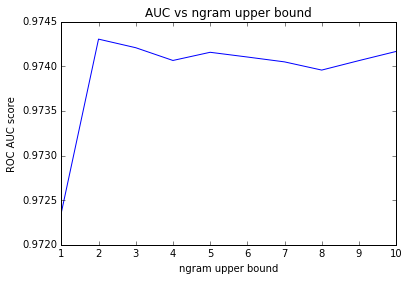

In [10]:
plt.plot(ngram_caps, aucs)
plt.title('AUC vs ngram upper bound')
plt.xlabel('ngram upper bound')
plt.ylabel('ROC AUC score')

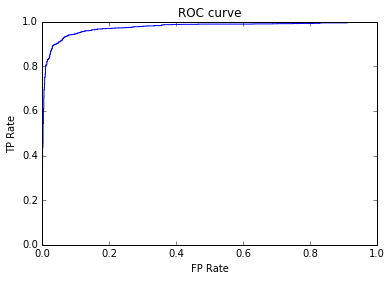

In [11]:
plt.figure()
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

# Non-text Model

[ 0.77345919  0.78789561  0.78622987  0.76790672  0.73403665]
LogReg
0.769905607996
0.746113989637
AUC: 0.831157994625
[ 0.91171571  0.9044975   0.91338145  0.90283176  0.90838423]
XGBoost
0.908162132149
0.911139896373
AUC: 0.969119973277
[ 0.93003887  0.93225986  0.93614659  0.92837313  0.93947807]
Random Forest
0.933259300389
0.939637305699
AUC: 0.974699604288
[ 0.78289839  0.7817879   0.7806774   0.7901166   0.74181011]
Naive Bayes
0.775458078845
0.776683937824
AUC: 0.855741586517


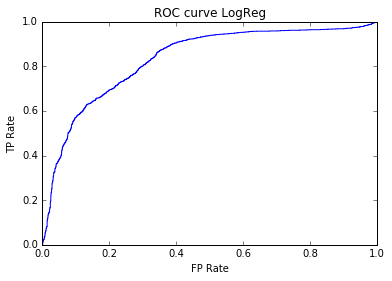

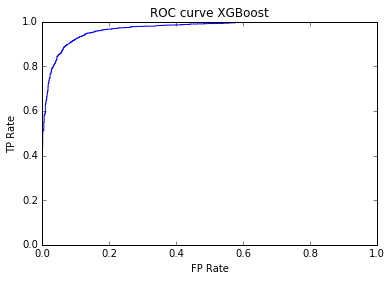

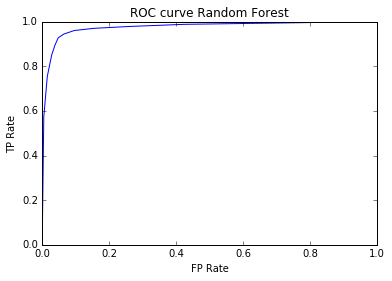

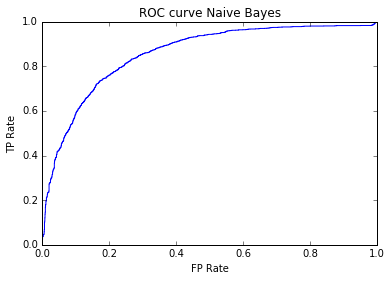

In [12]:
models = [LogisticRegression(), xgb(), rf(), GaussianNB()]
modelnames = ['LogReg','XGBoost','Random Forest','Naive Bayes']
for i in range(4):
    kfold = KFold(len(X_others_train), n_folds=5, shuffle=True, random_state=42)
    scores2 = cross_val_score(models[i], X_others_train, y_train, cv=kfold)
    print(scores2)
    print(modelnames[i])
    print(np.mean(scores2))
    

    # Build the Model
    models[i].fit(X_others_train, y_train)
    preds_ = models[i].predict(X_others_test)
    finalscore_ = sum(preds_ == y_test)/len(y_test)
    print(finalscore_)
    probs = models[i].predict_proba(X_others_test)
    roc = roc_curve(y_test, probs[:,1])
    auc = roc_auc_score(y_test, probs[:,1])
    print("AUC: " + str(auc))
    plt.figure()
    plt.plot(roc[0], roc[1])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')

In [13]:
preds

array([ True, False,  True, ...,  True,  True,  True], dtype=bool)

In [14]:
coefs = list(X_others_train.columns)
feats = list(models[2].feature_importances_)
for i in range(len(coefs)):
    print(str(coefs[i]) + ': ' + str(feats[i]))

favorite_count: 0.236174006348
retweet_count: 0.212696905045
percentPunctuation: 0.0805820758571
percentEscQ: 0.16511442725
percentInCaps: 0.0892737976269
numHastags: 0.0453092073581
numMentions: 0.0406448829924
manrt: 0.0392659500889
-H: 0.0103847738623
hour: 0.0511890550007
day: 0.0293649185712


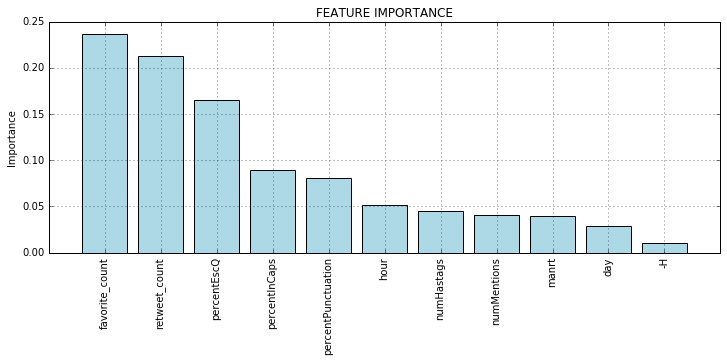

In [15]:
importances = models[2].feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = X_others_test.columns
feat_importance_dict = {}
feat_importance_dict[name] = sorted(zip(feat_labels,importances),key=lambda x: x[1])
plt.figure(figsize=(10,5))
plt.bar(range(X_others_test.shape[1]),
       importances[indices],
       color='lightblue',
       align='center')
plt.xticks(range(X_others_test.shape[1]),
          feat_labels[indices],rotation=90)
plt.xlim([-1,X_others_test.shape[1]])
plt.tight_layout()
plt.ylabel('Importance')
plt.title('FEATURE IMPORTANCE')
plt.grid()
plt.show()


LogReg

Test Score:0.960103626943
AUC: 0.991808109778

XGBoost

Test Score:0.961658031088
AUC: 0.993091482641

Random Forest

Test Score:0.969430051813
AUC: 0.987597508278

Naive Bayes

Test Score:0.959844559585
AUC: 0.991873224941


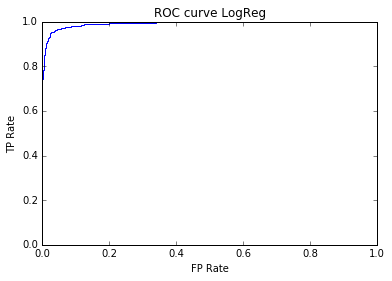

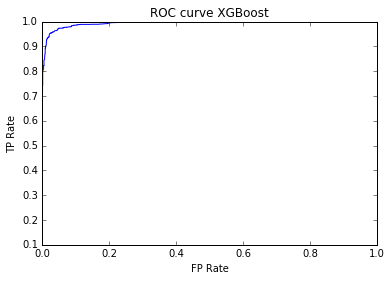

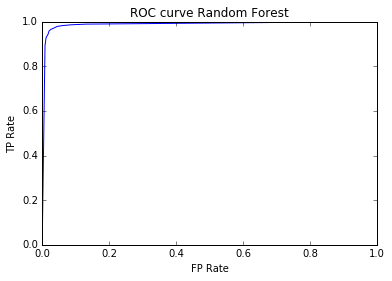

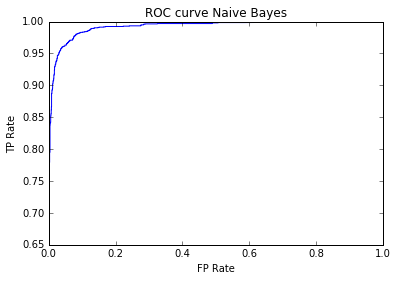

In [18]:
probstext = textmodel.predict_proba(X_text_test)[:,1]
probsnt = models[1].predict_proba(X_others_test)[:,1]

probstext_train = textmodel.predict_proba(X_text_train)[:,1]
probsnt_train = models[1].predict_proba(X_others_train)[:,1]

X_test2 = pd.DataFrame(data = probstext, columns = ['text'])
X_test2['nontext'] = probsnt

X_train2 = pd.DataFrame(data = probstext_train, columns = ['text'])
X_train2['nontext'] = probsnt_train

models2 = [LogisticRegression(), xgb(), rf(), GaussianNB()]
for i in range(4):
    kfold = KFold(len(X_train2), n_folds=5, shuffle=True, random_state=42)
    scores3 = cross_val_score(models2[i], X_train2, y_train, cv=kfold)
#     print(scores3)
    print('\n' + modelnames[i] + '\n')
#     print(np.mean(scores3))

    # Build the Model
    models2[i].fit(X_train2, y_train)
    preds__ = models2[i].predict(X_test2)
    finalscore__ = sum(preds__ == y_test)/len(y_test)
    print("Test Score:" + str(finalscore__))
    probs = models2[i].predict_proba(X_test2)
    roc = roc_curve(y_test, probs[:,1])
    auc = roc_auc_score(y_test, probs[:,1])
    print("AUC: " + str(auc))
    plt.figure()
    plt.plot(roc[0], roc[1])
    plt.title('ROC curve ' + modelnames[i])
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')